In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
from transformers import ViTForImageClassification, ViTConfig
from transformers import LevitForImageClassification, LevitConfig
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torchvision import models

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# Function to get predictions and probabilities
def get_predictions_and_probabilities(model, dataloader):
    model.eval()
    predictions = []
    actuals = []
    probabilities = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Evaluating {model.__class__.__name__}", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits
            probs = softmax(outputs, dim=1)[:, 1]  # Probability for class '1'
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.view(-1).cpu().numpy())
            actuals.extend(labels.view(-1).cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    return predictions, actuals, probabilities


In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset

class RealVFakeDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label, subdir in enumerate(['real', 'fake']):
            subdir_path = os.path.join(directory, subdir)
            for img_file in os.listdir(subdir_path):
                self.images.append(os.path.join(subdir_path, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label


In [12]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define the transformation pipeline
transform = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),


])


In [13]:
# Create a DataLoader for the test dataset
test_dataset = RealVFakeDataset('/content/real_vs_fake/real-vs-fake/test', transform)  # Replace with your test dataset path
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle for testing



In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model 1: Vision Transformer (ViT)
config1 = ViTConfig.from_pretrained('google/vit-base-patch16-224', num_labels=2)
# Load the model with pre-trained weights but ignore the classifier layer
model1 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', config=config1, ignore_mismatched_sizes=True)
# Load your custom trained weights for the model
model1.load_state_dict(torch.load('/content/drive/MyDrive/pretrained weights/vit_model_finetuned.pth', map_location=device), strict=False)
model1.to(device)



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [15]:
predictions1, actuals1, probabilities1 = get_predictions_and_probabilities(model1, test_loader)


Evaluating ViTForImageClassification: 100%|██████████| 625/625 [03:02<00:00,  3.42batch/s]


Model 1 test Accuracy: 0.9115
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10000
           1       1.00      0.83      0.90     10000

    accuracy                           0.91     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.91      0.91     20000

Model 1 - AUC Score: 0.9939179600000001 AP Score: 0.9942601266599427


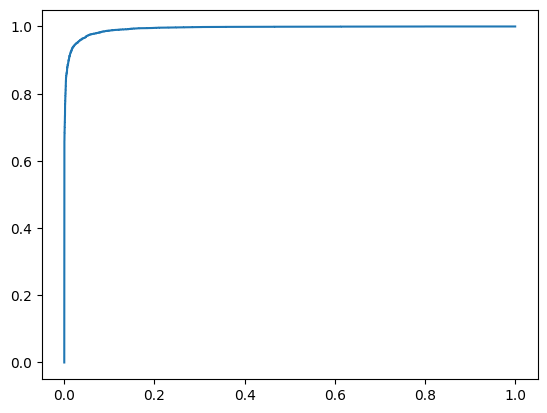

In [16]:
accuracy1 = accuracy_score(actuals1, predictions1)
print("Model 1 test Accuracy:", accuracy1)
print(classification_report(actuals1, predictions1))

# Calculate AUC and AP scores for each model
auc_score1 = roc_auc_score(actuals1, probabilities1)
ap_score1 = average_precision_score(actuals1, probabilities1)
print("Model 1 - AUC Score:", auc_score1, "AP Score:", ap_score1)

# Plot ROC curve
fpr1, tpr1, _ = roc_curve(actuals1, probabilities1)
plt.plot(fpr1, tpr1, label='Model 1')

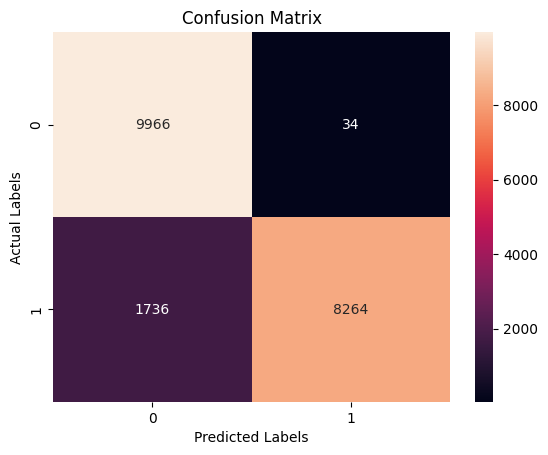

In [17]:

# Assuming actuals1 and predictions1 are defined from your previous code
cm = confusion_matrix(actuals1, predictions1)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [18]:
# Define the ConvolutionalVisionTransformer class
class ConvolutionalVisionTransformer(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ConvolutionalVisionTransformer, self).__init__()
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        in_features = self.vit.heads[0].in_features
        self.vit.heads = nn.Linear(in_features, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.vit(x)
        x = self.dropout(x)
        return x



In [19]:

valid_test_transform = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder(root='/content/real_vs_fake/real-vs-fake/test', transform=valid_test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



In [20]:
# Model 2: Convolutional Vision Transformer (ConvViT)

model2 = ConvolutionalVisionTransformer(num_classes=2, dropout_rate=0.5).to(device)
model2.load_state_dict(torch.load('/content/drive/MyDrive/pretrained weights/CNNViT_model.pth', map_location=device))
model2.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 103MB/s]


ConvolutionalVisionTransformer(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
    

In [21]:
predictions2, actuals2, probabilities2 = get_predictions_and_probabilities(model2, test_loader)


Evaluating ConvolutionalVisionTransformer: 100%|██████████| 313/313 [02:25<00:00,  2.14batch/s]


Model 2 test Accuracy: 0.9414
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.94      0.94      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Model 2 - AUC Score: 0.98675942 AP Score: 0.9873298012625674


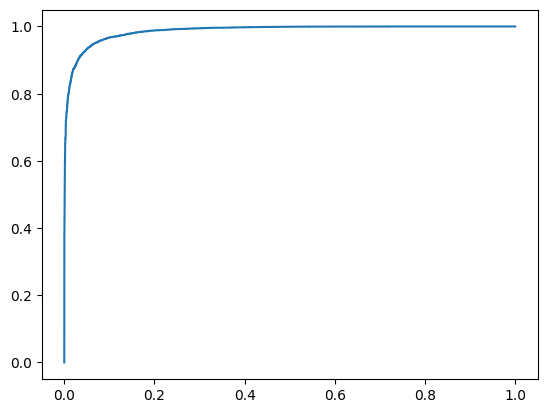

In [22]:
accuracy2 = accuracy_score(actuals2, predictions2)
print("Model 2 test Accuracy:", accuracy2)
print(classification_report(actuals2, predictions2))

auc_score2 = roc_auc_score(actuals2, probabilities2)
ap_score2 = average_precision_score(actuals2, probabilities2)
print("Model 2 - AUC Score:", auc_score2, "AP Score:", ap_score2)

fpr2, tpr2, _ = roc_curve(actuals2, probabilities2)
plt.plot(fpr2, tpr2, label='Model 2')

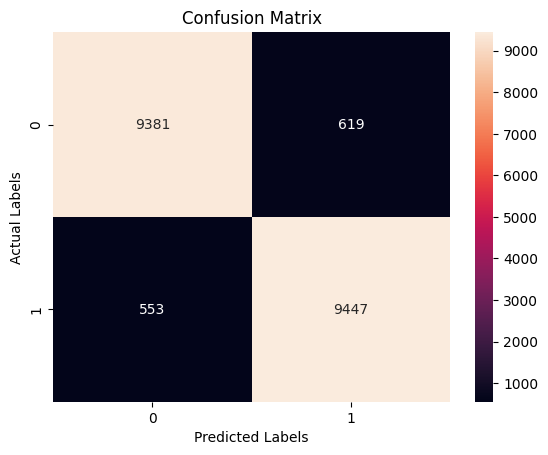

In [23]:
# Assuming actuals1 and predictions1 are defined from your previous code
cm = confusion_matrix(actuals2, predictions2)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [24]:
# Calculate AUC score for each model
auc1 = roc_auc_score(actuals1, probabilities1)
auc2 = roc_auc_score(actuals2, probabilities2)


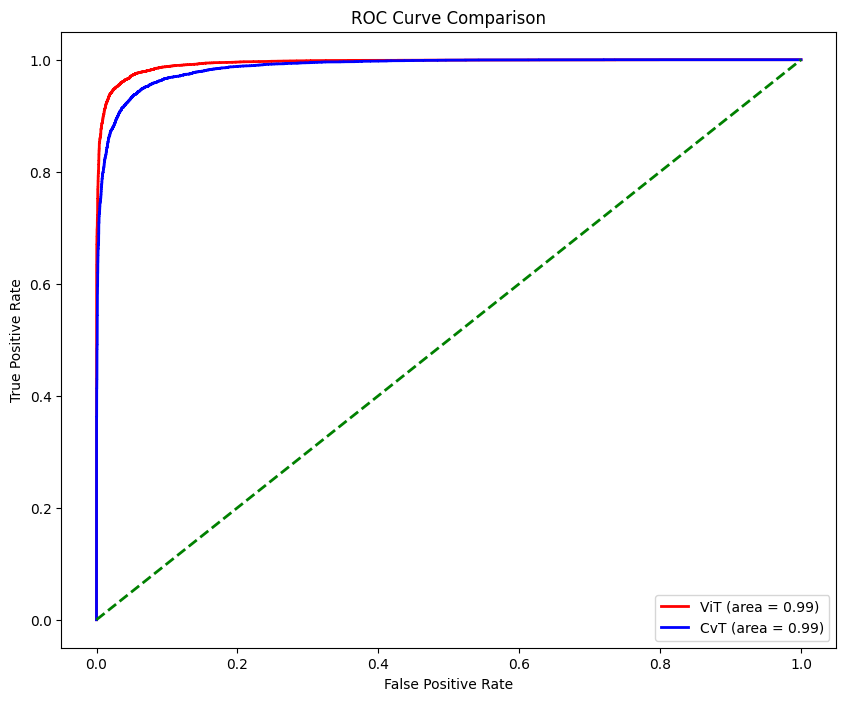

In [25]:
# Assuming fpr1, tpr1, roc_auc1, etc., are already calculated as shown previously

# Plot ROC curves with updated labels
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr1, tpr1, color='red', lw=lw, label=f'ViT (area = {auc1:.2f})')
plt.plot(fpr2, tpr2, color='blue', lw=lw, label=f'CvT (area = {auc2:.2f})')
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()
